# On-Chain Metrics & Price

#### Goal: What On-Chain Metrics have the largest affect on ETH price?
#### How Do Different Regression Algorithms perform with On-Chain Metrics?

On-Chain metrics have incredible predictive powers when it comes to measures of price action. Considering important on-Chain metrics, I am setting out to answer the question quantitatively what on-chain metrics lead to changes in price. 

Upon dissecting various chains, I hope to compare chains with different functionality. For example after considering BTC's on-chain metrics, I would like to discover how these matrics may affect L1's differently from defi protocols 

Using Glassnode api key. Has tons of data available & easy to work with.

In [405]:
#imports
import numpy as np
import pandas as pd
import json
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')

In [344]:
# Glassnode API to create a dataframe. 

API_KEY = '2AWlM3FJda1LoK0Eq4pDADN96d6'

urls = ['https://api.glassnode.com/v1/metrics/addresses/count',
       'https://api.glassnode.com/v1/metrics/addresses/active_count',
       'https://api.glassnode.com/v1/metrics/addresses/new_non_zero_count',
       'https://api.glassnode.com/v1/metrics/blockchain/block_height',
       'https://api.glassnode.com/v1/metrics/market/marketcap_usd',
       'https://api.glassnode.com/v1/metrics/mining/difficulty_latest',
       'https://api.glassnode.com/v1/metrics/mining/hash_rate_mean',
       'https://api.glassnode.com/v1/metrics/addresses/min_1_count',
       'https://api.glassnode.com/v1/metrics/addresses/min_10_count',
       'https://api.glassnode.com/v1/metrics/addresses/min_1k_count',
       'https://api.glassnode.com/v1/metrics/market/price_usd_close']

data = []
for url in urls:
    label = url.split('/')[-1]
    res = requests.get(url, params = {'a':'ETH','api_key':API_KEY})
    df = pd.read_json(res.text, convert_dates=['t'])
    df.set_index('t', inplace = True)
    df.rename(columns = {'v':label}, inplace = True)
    data.append(df)
eth_df = pd.concat(data, axis=1)

In [345]:
# Although dropping nan values significantly reduces the up-to-dateness of this data-set,
# it is required to fit regression models with numeric values without any nans
# Future upgrades to this analysis will likely include better data preparation in order to
# obtain more up to date results. See last row of df with a date of 06/13/2021
eth_df = eth_df.dropna()
eth_df

,count,active_count,new_non_zero_count,block_height,marketcap_usd,difficulty_latest,hash_rate_mean,min_1_count,min_10_count,min_1k_count,price_usd_close
t,,,,,,,,,,,
2015-08-08,10641.0,800.0,353.0,55869.0,5.567566e+07,1.606016e+12,9.644985e+10,9848.0,9502.0,5169.0,0.769981
2015-08-09,10894.0,731.0,253.0,60992.0,5.206894e+07,1.741399e+12,1.013969e+11,9904.0,9518.0,5122.0,0.719830
2015-08-10,11543.0,997.0,649.0,66247.0,5.070503e+07,1.948102e+12,1.116431e+11,9982.0,9547.0,5092.0,0.700705
2015-08-11,13432.0,2339.0,1889.0,71527.0,7.878741e+07,2.171897e+12,1.240757e+11,10008.0,9537.0,5077.0,1.088361
2015-08-12,13744.0,904.0,312.0,76651.0,8.792091e+07,2.248238e+12,1.308930e+11,10082.0,9571.0,5061.0,1.214071
...,...,...,...,...,...,...,...,...,...,...,...
2021-06-09,119511453.0,493953.0,91027.0,12603434.0,3.029648e+11,7.724041e+15,5.795195e+14,1214118.0,262106.0,6343.0,2606.671122
2021-06-10,119605803.0,495839.0,94350.0,12609896.0,2.873543e+11,7.614328e+15,5.682564e+14,1212397.0,262081.0,6352.0,2472.075768
2021-06-11,119698671.0,477229.0,92868.0,12616350.0,2.733762e+11,7.620172e+15,5.687904e+14,1213488.0,262044.0,6342.0,2351.552120


# All Variables Plotted Against Each Other

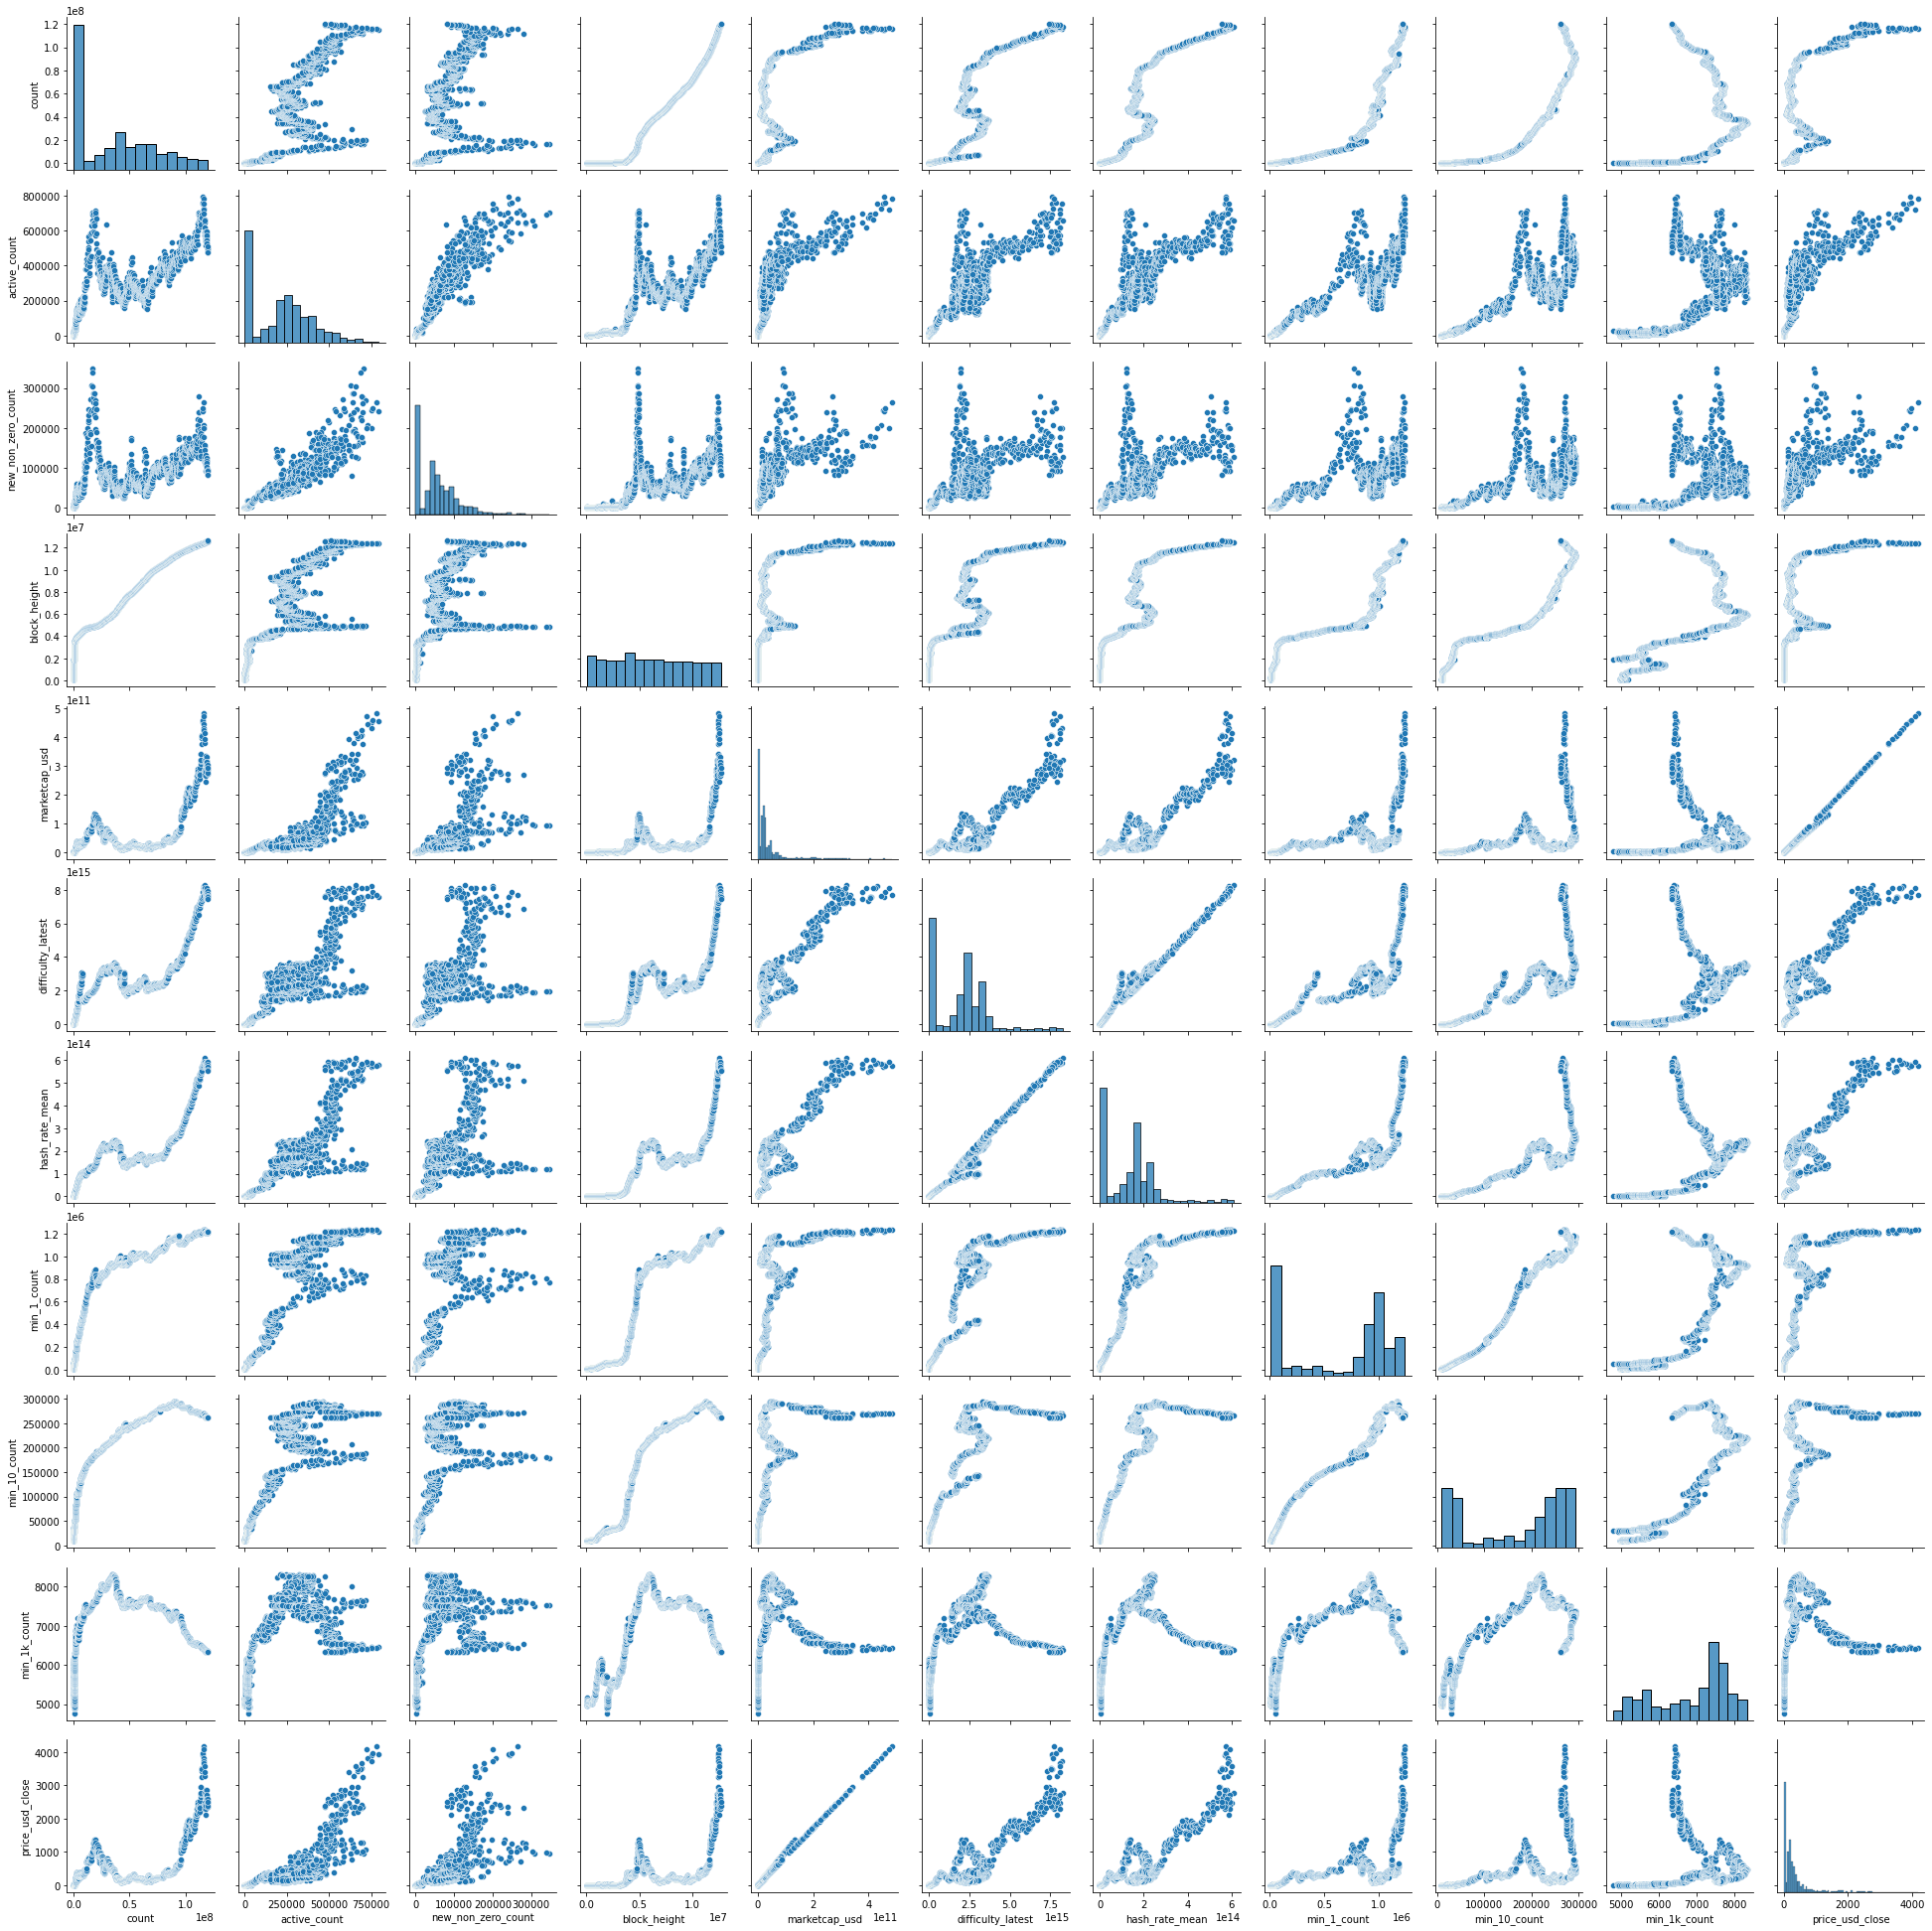

In [346]:
sns.pairplot(eth_df.loc[:, :'price_usd_close'])

###  Feature Analysis

Intial analysis indiactes many of these metrics have relatively positive correlatations. This is good news for our models especially of the linear variety. Disregard correlation between mcap and price due to their completely linear nature. 

# OLS Model

In [371]:
eth_price = eth_df['price_usd_close']
X = eth_df[['count','active_count','new_non_zero_count','block_height','difficulty_latest','hash_rate_mean','min_1_count','min_10_count','min_1k_count']]
X = sm.add_constant(X) 
model = sm.OLS(eth_price, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_usd_close   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     4055.
Date:                Tue, 14 Jun 2022   Prob (F-statistic):               0.00
Time:                        11:32:15   Log-Likelihood:                -13630.
No. Observations:                2137   AIC:                         2.728e+04
Df Residuals:                    2128   BIC:                         2.733e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               3.389e-07   3.98e-07      0.852      0.394   -4.41e-07    1.12e-06
count              -7.953e-07   5.91e-07     -1.346      0.179   -1.95e-06    3.64e-07
active_count           0.0005      0.000      4.132      0.000       0.000       0.001
new_non_zero_count     0.0036      0.000     16.074      0.000       0.003       0.004
block_height        4.085e-05   7.62e-06      5.361      0.000    2.59e-05    5.58e-05
difficulty_latest   5.374e-14   1.57e-14      3.422      0.001    2.29e-14    8.45e-14
hash_rate_mean      4.583e-12    2.7e-13     16.961      0.000    4.05e-12    5.11e-12
min_1_count           -0.0007      0.000     -6.714      0.000      -0.001      -0.001
min_10_count          -0.0026      0.001     -4.894      0.000      -0.004      -0.002
min_1k_count           0.0017      0.002      0.826      0.409      -0.002       0.006
==============================================================================
Omnibus:                      659.549   Durbin-Watson:                   0.195
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6170.880
Skew:                           1.178   Prob(JB):                         0.00
Kurtosis:                      10.984   Cond. No.                     6.41e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.41e+16. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# OLS Analysis

- R-squared:
    - Measurement of how much the dependent variable is explained by changes in the independent variables. An r^2 of .938 indicates the model explains 93.8% of the change in the price_close_usd variable. 
- F-statistic:
    - The F-statistic compares your produced linear model for your variables against a model that replaces your variables’ effect to 0, to find out if your group of variables are statistically significant. To interpret this number correctly, using a chosen alpha value and an F-table is necessary. 
- Prob (F-Statistic):
    - Uses this number to tell you the accuracy of the null hypothesis, or whether it is accurate that your variables’ effect is 0. In this case, it is telling us 0% chance of this.
- coef
    - For each variable coef is the measurement of how change in that specific variable affects the dependent variable (price_close_usd). We can see that each coef in the covariates in very close to 0 meaning that there is a very limited causal relationship between individual covariates and the dependent variable.
- std error
    - standard deviation of the coefficient. This is also very small indicating that the coef value is likely around 0 as described in coef section above.
- P > |t|
    - Uses the t statistic to produce the p value, a measurement of how likely the coef is measured through the model by chance. The p-val of .411 for covariate min_1k_count means there is a 41.1% chance of min_1k_count has no affect on the dependent variable. Many of the other covariates are statistically significant. 
- [0.025 ---- 0.975]
    - measurement values of coef within 95% of data (2std). Anything outside of this are considered outliers. 
- Omnibus and prob(Omnibus)
    - Describes the distribution of the residuals. 0 indicates normal distribution 
- Skew
    - measurement of symmetry of data. 0 --> perfectly symmetrical 
- Kurtosis
    - measurement of peakiness of data. Higher kurtosis indicates fewer outliers.

# What does this OLS Analysis mean?

Finish this up later. Intial ideas is that these on chain metrics do have statistical significance when it comes to price fluctuation of the network. This verifies that on-chain data can be leveraged in order to more intelligently invest in digital assets. 

This leads to a few different future questions:
- What other on-chain metrics have significance?
- How does the significance of on-chain metrics of L1's vary from coins/tokens of other use cases?
    - Are there certian on-chain metrics that may have an outsized affect on future price for L1's, for L2's?

## More Regression Models: Linear, Tree-Based, Ensemble

Statistical Regression is a method of estimating a dependent variable based on one or more independent variables. In this case the dependent variable was eth_df.price_usd_close (eth price at close) and the independent was 9 variables:
- count: The total number of unique addresses that ever appeared in a transaction of the native coin in the network.
- active_count: The number of unique addresses that were active either as a sender or receiver. Only addresses that were active in successful transactions are counted.
- new_non_zero_count: The number of unique addresses holding a positive (non-zero) amount of coins. For Ethereum only Externally Owned Addresses (EOAs) are counted, contracts are excluded.
- block_height: The block height, i.e. the total number of blocks ever created and included in the main blockchain.
- difficulty_latest: The current estimated number of hashes required to mine a block. Note: Bitcoin difficulty is often denoted as the relative difficulty with respect to the genesis block, which required approximately 2^32 hashes. For better comparison across blockchains, our values are denoted in raw hashes.
- hash_rate_mean: The average estimated number of hashes per second produced by the miners in the network.
- min_1_count: The number of unique addresses holding at least 1 coin. For Ethereum only Externally Owned Addresses (EOAs) are counted, contracts are excluded.
- min_10_count: The number of unique addresses holding at least 10 coins. For Ethereum only Externally Owned Addresses (EOAs) are counted, contracts are excluded.
- min_1k_count: The number of unique addresses holding at least 1k coins. For Ethereum only Externally Owned Addresses (EOAs) are counted, contracts are excluded.

##### Future improvement of this analysis would include more on-chain metrics that inlcude but are not limited to addresses, mining, transactions, DeFi, derivatives, distribution, fees, indicators, and institutional activity. 

##### These metrics were more or less arbitrarily picked to validate on-chain metrics as methods of driving sound investment decisions. 

In [376]:
#Train Test Split for all future regression models
X = eth_df[['count','active_count','new_non_zero_count','block_height','difficulty_latest','hash_rate_mean','min_1_count','min_10_count','min_1k_count']]
eth_price = eth_df['price_usd_close']
X, y = X, eth_price
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30, random_state = 0)
print (f'Training Set: {X_train.shape[0]} rows \nTest Set: {X_test.shape[0]} rows')

Training Set: 1495 rows 
Test Set: 642 rows


In [377]:
#Function to check Mean Squared Error, Root Mean Squared Error, and r^2
def model_fit(y_test, preds):
    mse = mean_squared_error(y_test, preds)
    print(f'Mean Squared Error: {mse}')
    rmse = np.sqrt(mse)
    print(f'Root Mean Squared Error: {rmse}.\nSimply put, this means that each prediction was, on average, ${rmse.round(2)} different from actual.')
    r2 = r2_score(y_test, preds)
    print("r^2:", r2)

In [396]:
#Function to plot the predicted vs actual in the model
def preds_act_plot(y_test, preds):
    plt.figure(figsize=(8, 6), dpi=80)
    plt.scatter(y_test, preds)
    plt.xlabel('Actual Labels')
    plt.ylabel('Predicted Labels')
    plt.title('Predicted vs Actual eth Price')
    z = np.polyfit(y_test, preds, 1)
    p = np.poly1d(z)
    plt.plot(y_test,p(y_test), color='magenta')
    plt.show()

In [379]:
def price_date_plot(preds):
    plt.figure(figsize=(8, 6), dpi=80)
    preds = model.predict(X)
    plt.plot(eth_df.index, preds, label = 'predicted', color = 'red')
    plt.plot(eth_df.index,eth_price, label = 'actual', color = 'blue')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('eth price')
    plt.title('eth price vs date')

### OLS (Linear)

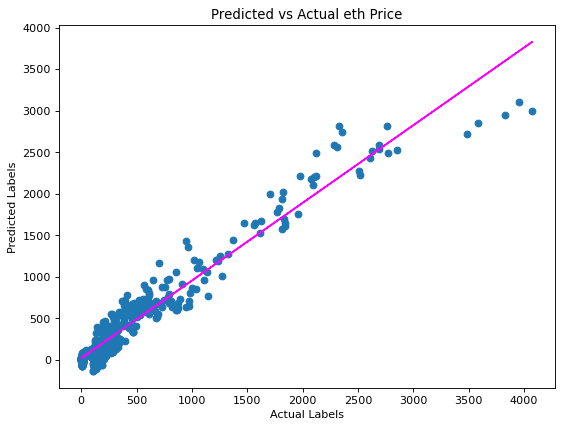

Mean Squared Error: 21235.61293804031
Root Mean Squared Error: 145.72444180040736.
Simply put, this means that each prediction was, on average, $145.72 different from actual.
r^2: 0.9382441803546113


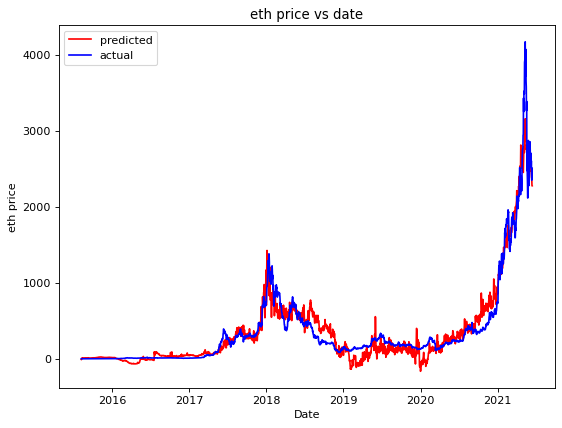

In [381]:
model = LinearRegression().fit(X_train, y_train)
preds = model.predict(X_test)
preds_act_plot(y_test, preds)
model_fit(y_test, preds)
price_date_plot(preds)

### Lasso (Linear)

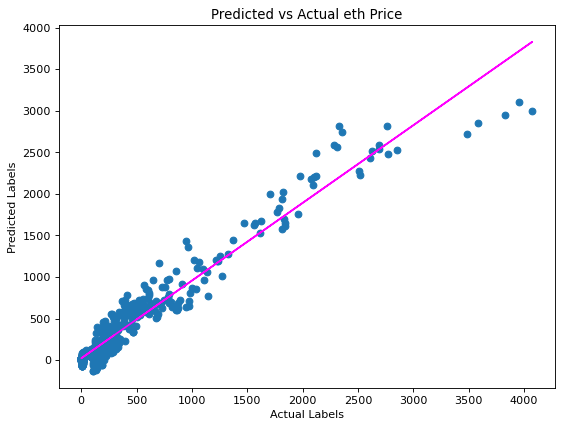

Mean Squared Error: 21246.207246027487
Root Mean Squared Error: 145.76078775180753.
Simply put, this means that each prediction was, on average, $145.76 different from actual.
r^2: 0.9382133707813142


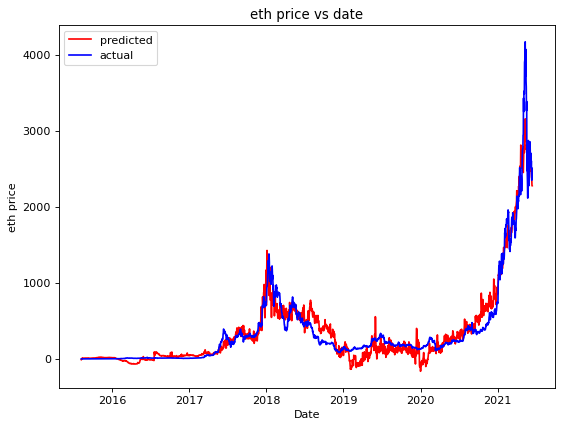

In [382]:
model = Lasso().fit(X_train, y_train)
preds = model.predict(X_test)
preds_act_plot(y_test, preds)
model_fit(y_test, preds)
price_date_plot(preds)

##### What is a Linear Lasso Regression Model?
[sklearn docs](https://scikit-learn.org/stable/modules/linear_model.html#lasso): A lasso regression model is slightly from a linear regression model. The model is penalized for sum of absolute values of the weights.

### Decision Tree (Tree-based)

In [384]:
model = DecisionTreeRegressor().fit(X_train, y_train)
preds = model.predict(X_test)

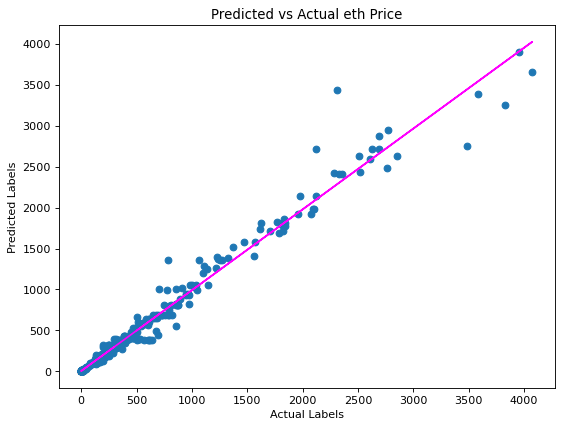

Mean Squared Error: 7388.807147356069
Root Mean Squared Error: 85.95817091676666.
Simply put, this means that each prediction was, on average, $85.96 different from actual.
r^2: 0.9785124242508072


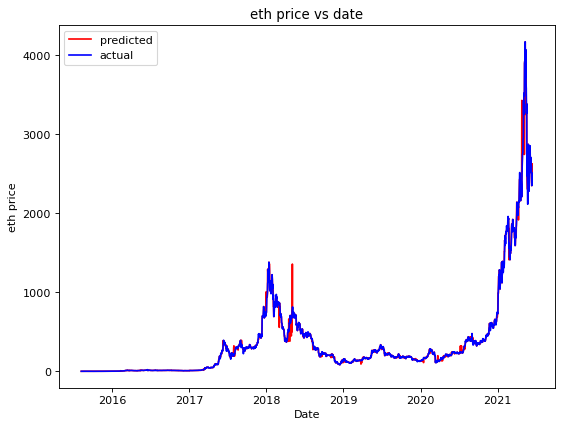

In [385]:
preds_act_plot(y_test, preds)
model_fit(y_test, preds)
price_date_plot(preds)

##### What is a Decision Tree Regression Model?
[sklearn docs](https://scikit-learn.org/stable/modules/tree.html#tree): A decision tree regression model aims to predict a value by inflection, or decision, points inferred from the data's features -- "Piecewise constant approximation"

### Random Forest (Ensemble)

In [387]:
model = RandomForestRegressor().fit(X_train, y_train)
preds = model.predict(X_test)

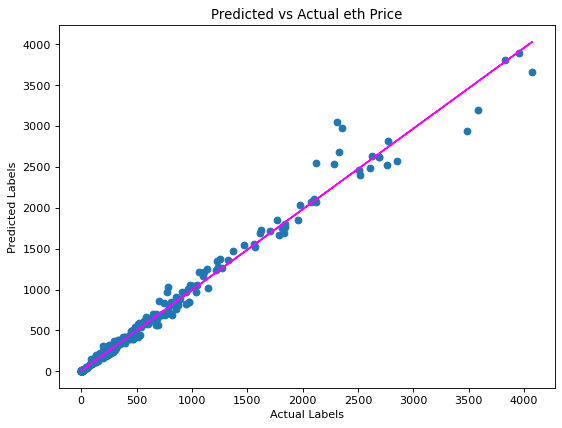

Mean Squared Error: 4398.676195645564
Root Mean Squared Error: 66.32251650567524.
Simply put, this means that each prediction was, on average, $66.32 different from actual.
r^2: 0.9872080992147797


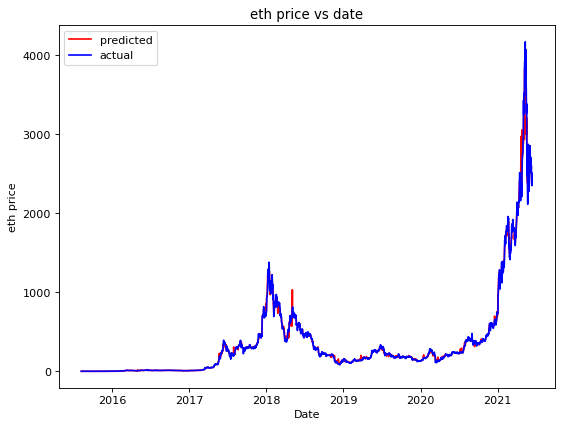

In [388]:
preds_act_plot(y_test, preds)
model_fit(y_test, preds)
price_date_plot(preds)

##### What is a Random Forest Regression Model?
[sklearn docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html): A random forest is regression method that combines multiple previous classification decision trees on sections of the data using averaging to improve the accuracy and handle over-fitting.

### Gradient Boosting (Ensemble)

In [399]:
model = GradientBoostingRegressor().fit(X_train, y_train)
preds = model.predict(X_test)

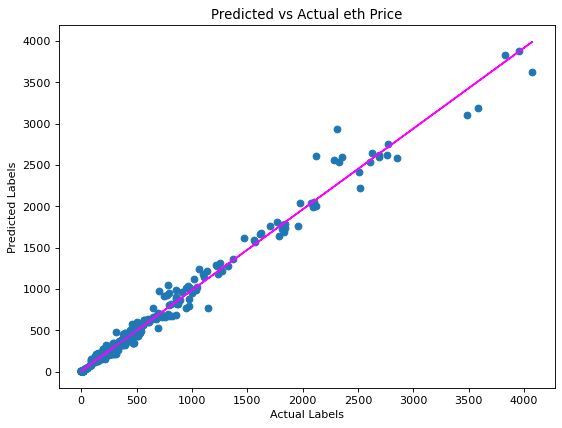

Mean Squared Error: 4407.330155658278
Root Mean Squared Error: 66.38772594130845.
Simply put, this means that each prediction was, on average, $66.39 different from actual.
r^2: 0.9871829324161889


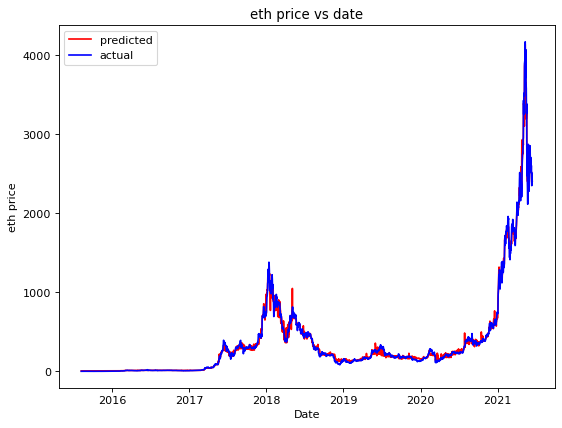

In [400]:
preds_act_plot(y_test, preds)
model_fit(y_test, preds)
price_date_plot(preds)

##### What is a Gradient Boosting Regression Model?
[sklearn docs](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html): Gradient boosting produces a predictive model based on an ensemble of weak predictive models. It is like a random forest; howeverm instead of building the trees independently and taking the average, each tree is built on the outputs of the last to incrementally reduce error.


# Take Aways, Comments, Future Questions

### Comments:
- There are obviously many ways to tune this model in order to imporve performance of each model. This would include importing the sklearn.preprocessing module in order use various methods (MinMaxScalar, StandardScaler, LabelEncoder, Normalize).
    - MinMaxScalar: Crunches down the range of values in each column to a given range.
    - StandardScaler: Standardize fearures by removing the mean and scaling to unit variance. Standard score of sample x: z = (x-u)/s. u -- mean of training samples, s -- std of training samples
    - LabelEncoder: Encode target labels between 0 and n_classes-1. Note -- this wouldn't be able to be used due to the numeric nature of eth_df.price_usd_close
    - normalize: Scale input vectors between 0 and 1
- Additionally this would include hyperparameter tuning on the models themselves using sklearn.model_selection.GridSearchCV.
    - GridSearchCV: Essentially searches over specified range for best hyper parameters. Uses cross-validated grid search over parameter grid.
######  The seemingly random usage of regression models applied is used so I can go back and reference syntax + documentation. Also used to see if there is a best regression model for crypto on-chain data to automatically use. 
### Take Aways:
- Given the ability for these regression models to predict prive with very low Mean Squared Error, Root Mean Squared Error, and high R^2 values, we can say with confidence that on-chain metrics are valid predictors of price. Additionally, the metrics used were picked sparingly. Increased the amount of independent variables in these regression would only improve the quantified measures of error. 

### Future Questions
- Since regression models work to validate that on-chain metrics are functional in predicting price, may we use classification models to predict whether the eth price will rise or fall under various timeframes: 1d, 7d, 30d, 90d, 120d. 
- Further use of regression models may also be able to tell use which metrics are best suited for price predictions for blockchains of varying functions. Using ETH as a standard for analysis seems reasonable.  